In [1]:
import pandas as pd
import numpy as np

hotels_df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-11/hotels.csv')

In [2]:
hotels_df.drop(axis = 1, columns = ['arrival_date_day_of_month', 'arrival_date_week_number',
                                    'arrival_date_year','reservation_status','reservation_status_date', 
                                    'company'], inplace = True)

In [3]:
hotels_df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

<Figure size 640x480 with 0 Axes>

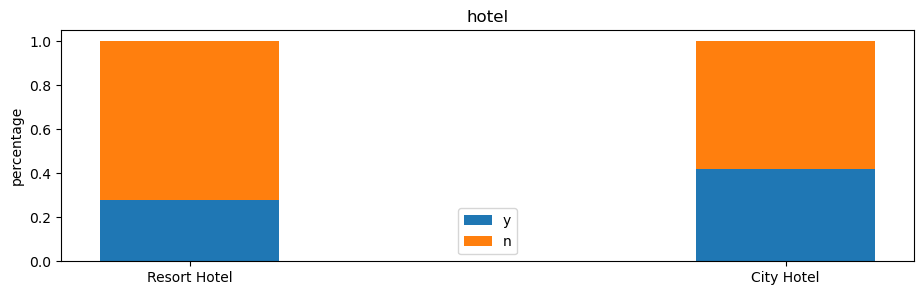

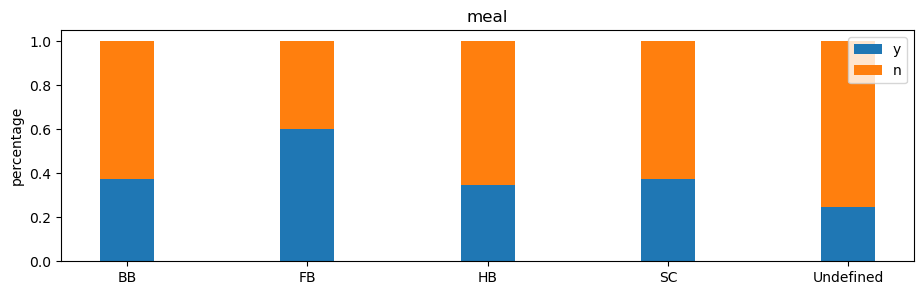

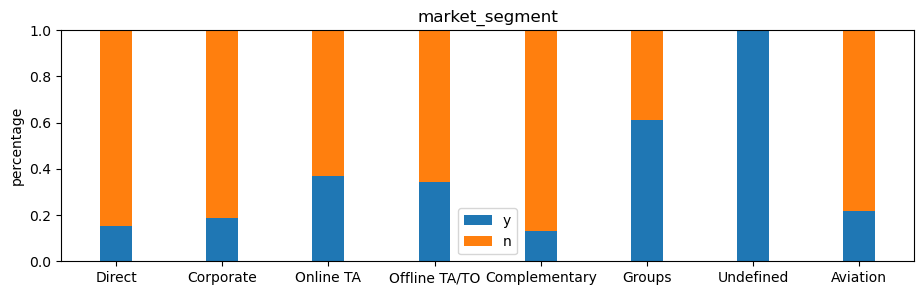

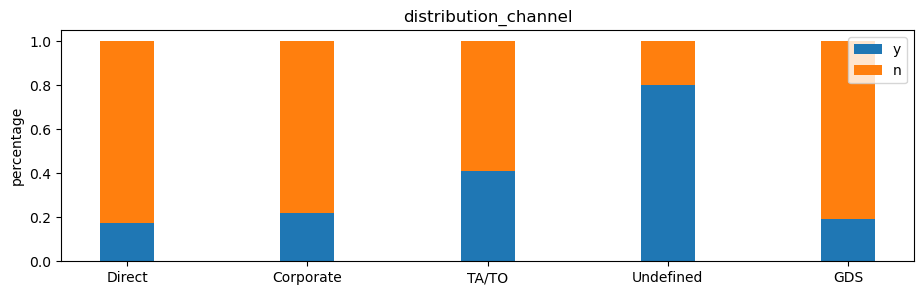

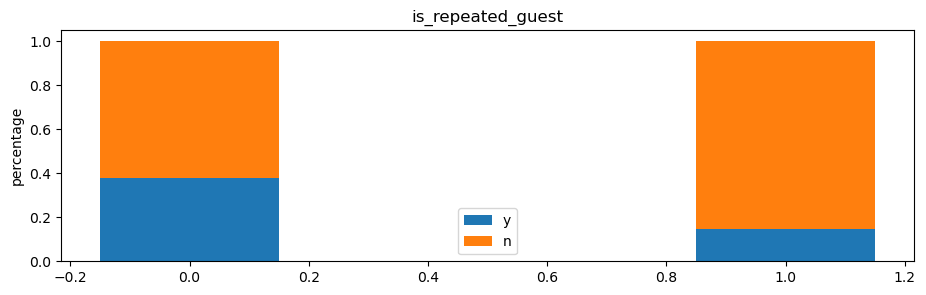

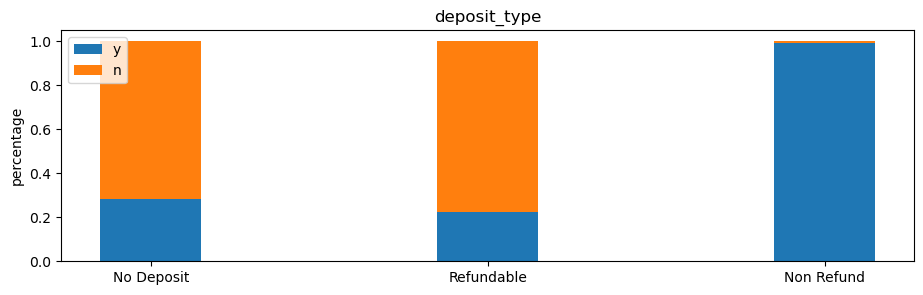

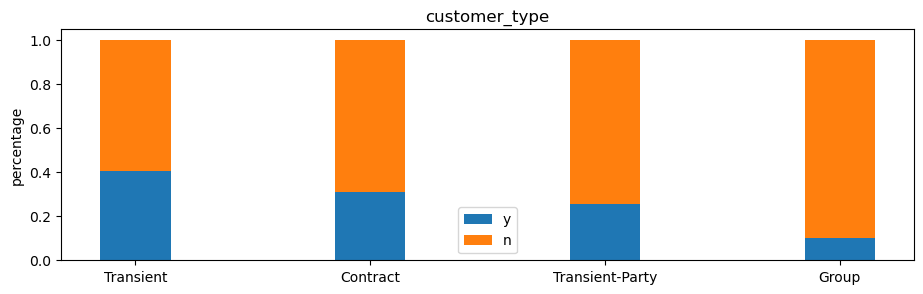

In [4]:
import matplotlib.pyplot as plt

i = 1
for col in hotels_df.columns:
    if (hotels_df[col].dtype == 'object' or col == 'is_repeated_guest') and hotels_df[col].nunique() < 10:
        categories = hotels_df[col].unique()
        y = []
        n = []
        for instance in categories:
            y_p = sum(hotels_df['is_canceled'].loc[hotels_df[col] == instance])
            y_p = y_p/len(hotels_df['is_canceled'].loc[hotels_df[col] == instance])
            n_p = 1 - y_p
            y.append(y_p)
            n.append(n_p)
        plt.figure(i)
        plt.figure(figsize = (11, 3)) 
        plt.bar(categories, y, 0.3, label = 'y')
        plt.bar(categories, n, 0.3, bottom = y, label = 'n')
        plt.title(col)
        plt.ylabel("percentage")
        plt.legend()
        i = i + 1
plt.show()

/var/folders/b0/5_73q1l546q7w5qttn4p1l480000gn/T/ipykernel_1624/3755639117.py:7: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density_y = kde.gaussian_kde(hotels_df[col].loc[hotels_df['is_canceled'] == 1])
/var/folders/b0/5_73q1l546q7w5qttn4p1l480000gn/T/ipykernel_1624/3755639117.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density_n = kde.gaussian_kde(hotels_df[col].loc[hotels_df['is_canceled'] == 0])


<Figure size 640x480 with 0 Axes>

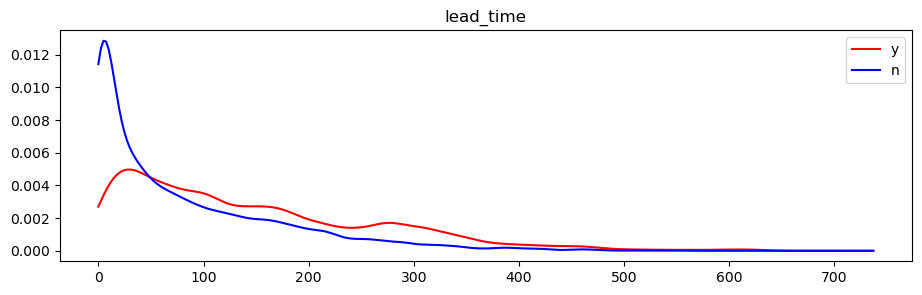

<Figure size 640x480 with 0 Axes>

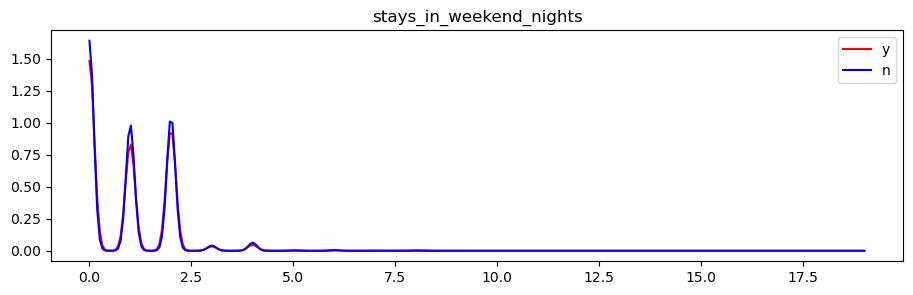

<Figure size 640x480 with 0 Axes>

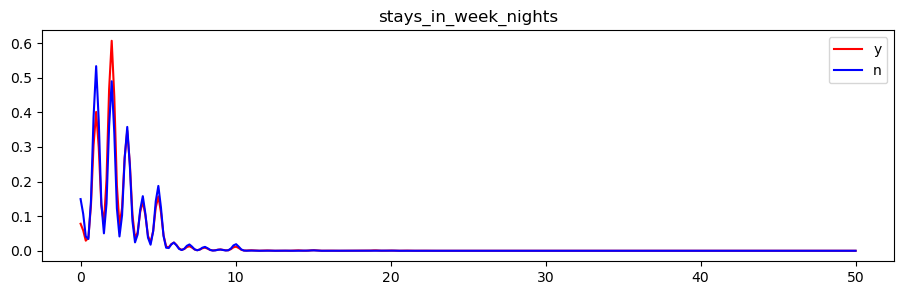

<Figure size 640x480 with 0 Axes>

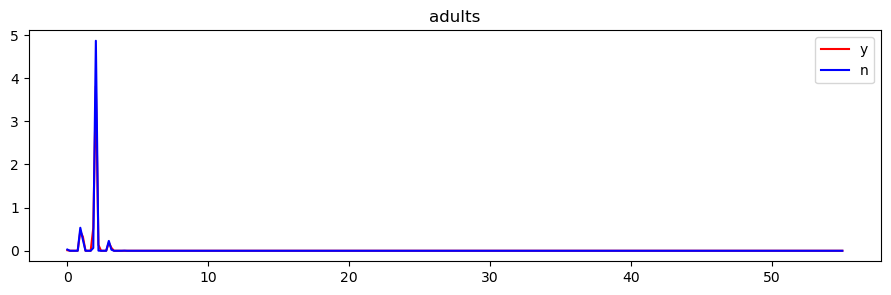

<Figure size 640x480 with 0 Axes>

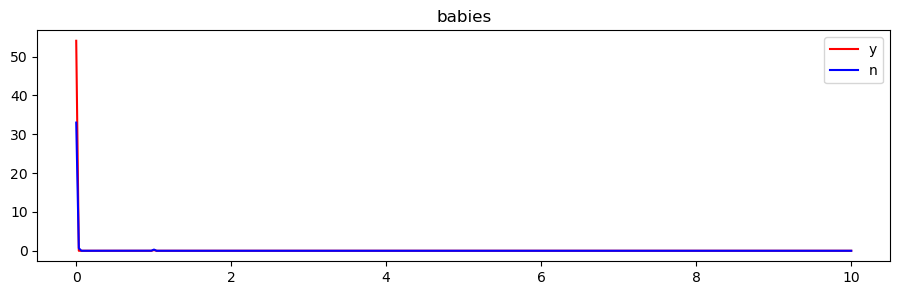

<Figure size 640x480 with 0 Axes>

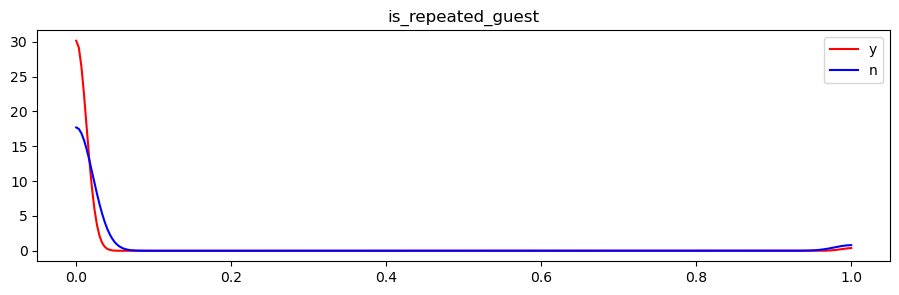

<Figure size 640x480 with 0 Axes>

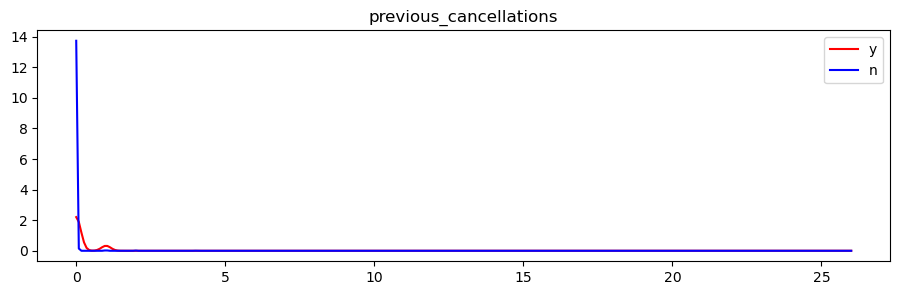

<Figure size 640x480 with 0 Axes>

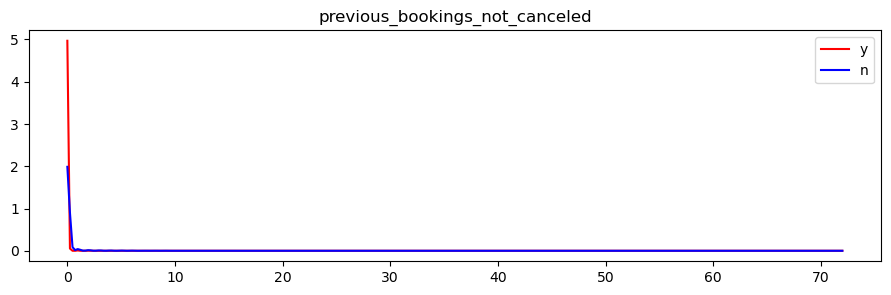

<Figure size 640x480 with 0 Axes>

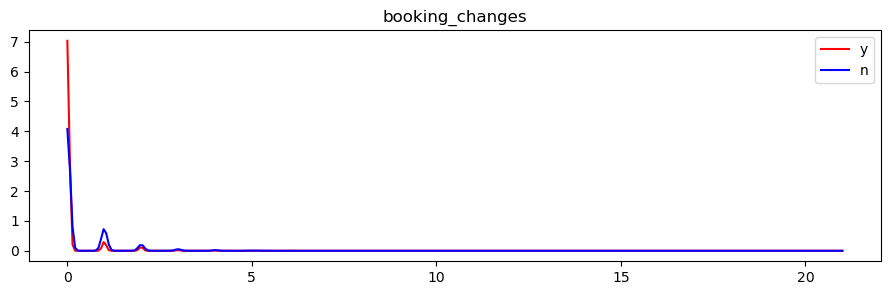

<Figure size 640x480 with 0 Axes>

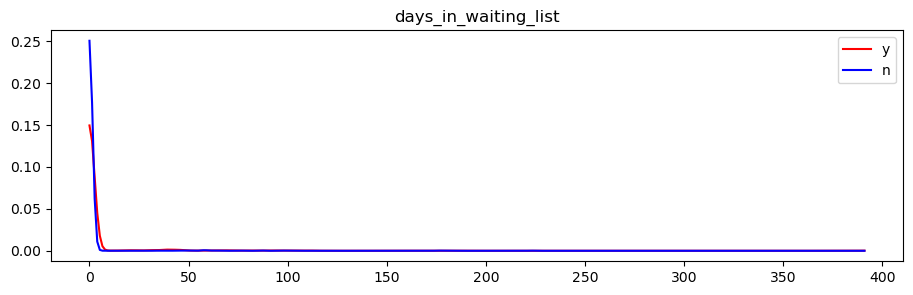

<Figure size 640x480 with 0 Axes>

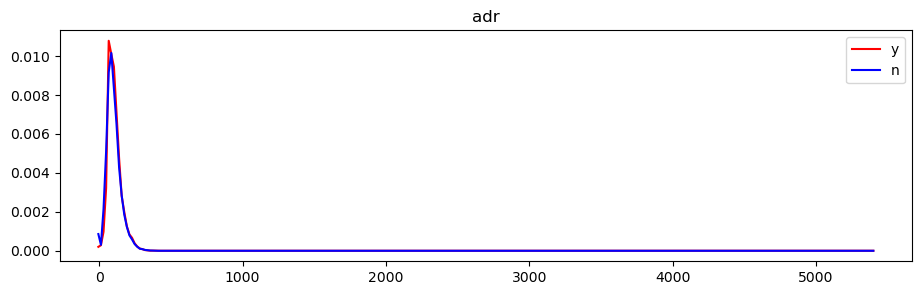

<Figure size 640x480 with 0 Axes>

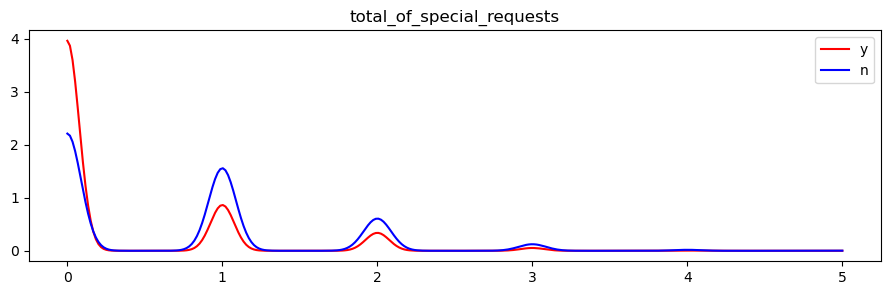

In [5]:
from scipy.stats import kde

i = 1
for col in hotels_df.columns:
    if hotels_df[col].dtype != 'object':
        try:
            density_y = kde.gaussian_kde(hotels_df[col].loc[hotels_df['is_canceled'] == 1])
        except:
            continue
        density_n = kde.gaussian_kde(hotels_df[col].loc[hotels_df['is_canceled'] == 0])
        x = np.linspace(np.min(hotels_df[col]),np.max(hotels_df[col]), 300)
        y_y = density_y(x)
        y_n = density_n(x)
        
        plt.figure(i)
        plt.figure(figsize = (11, 3)) 
        plt.plot(x, y_y, 'r-', label = 'y')
        plt.plot(x, y_n, 'b-', label = 'n')
        plt.title(col)
        plt.legend()
        plt.show()
        i = i + 1

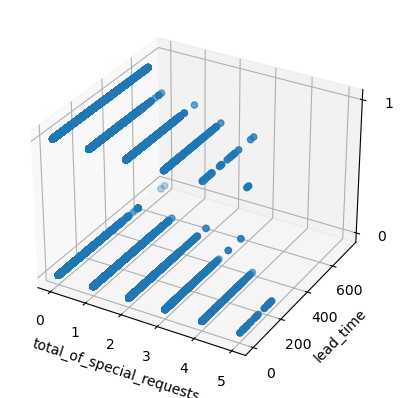

In [6]:
# plot the 2 variables of highest correlation to the variable to be predicted

fig = plt.figure()
plot = fig.add_subplot(projection='3d')

x = hotels_df['total_of_special_requests']
y = hotels_df['lead_time']
z = hotels_df['is_canceled']

plot.scatter(x, y, z)
plot.set_xlabel('total_of_special_requests')
plot.set_ylabel('lead_time')
plot.set_zticks([0, 1])
plot.set_zlabel('is_canceled')

plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

train_set, test_set = train_test_split(hotels_df, test_size = 0.4, random_state = 42)
X_train = train_set.drop(axis = 1, columns = ['is_canceled'])
y_train = train_set['is_canceled']
X_test = test_set.drop(axis = 1, columns = ['is_canceled'])
y_test = test_set['is_canceled']

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

categorical_transform1 = Pipeline([
    ("impute", SimpleImputer(strategy = "constant", fill_value = " ")),
    ("OH_encode", OneHotEncoder(handle_unknown = "ignore", sparse = False))
])

categorical_transform2 = Pipeline([
    ("impute", SimpleImputer(strategy = "constant", fill_value = " ")),
    ("O_encode", OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1))
])

full_pipeline = ColumnTransformer([
    ("numerical", SimpleImputer(strategy = "median"), [col for col in X_train.columns if X_train[col].dtype != 'object']),
    ("categorical_type1", 
     categorical_transform1, 
     [col for col in X_train.columns if (X_train[col].dtype == 'object' and X_train[col].nunique() <= 15)]),
    ("categorical_type2", 
     categorical_transform2, 
     [col for col in X_train.columns if (X_train[col].dtype == 'object' and X_train[col].nunique() > 15)])
])

full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("model", XGBClassifier(max_depth = 10,
                            n_estimators = 200,
                            n_jobs = -1,
                            random_state = 42))
])
            

In [10]:
# Encountered Issue with grid search -- taking far too long to process
from sklearn.model_selection import GridSearchCV

param_grid = [ {'model__n_estimators': [100, 200, 350, 500] ,
                 'model__n_jobs': [-1], 
                 'model__random_state':[42],
                 'model__max_depth': [4, 10, 25]} ]

grid_search = GridSearchCV(full_pipeline_with_predictor, 
                           param_grid, cv = 3, n_jobs = -1, scoring = 'roc_auc', 
                           return_train_score = True)

In [ ]:
#grid_search.fit(X_train, y_train)
#grid_search.best_params_

/Users/sahilkabir/Dev/DataSci/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sahilkabir/Dev/DataSci/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sahilkabir/Dev/DataSci/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sahilkabir/Dev/DataSci/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was rename

In [12]:
full_pipeline_with_predictor.fit(X_train, y_train)

/Users/sahilkabir/Dev/DataSci/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('numerical',
                                                  SimpleImputer(strategy='median'),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes', 'agent',
                                                   'days_in_waiting_list',
                                                   'adr',
                                                   'required_car_par...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [13]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

y_testpred = full_pipeline_with_predictor.predict(X_test)

print(precision_score(y_test, y_testpred))
print(recall_score(y_test, y_testpred))
print(roc_auc_score(y_test, y_testpred))

0.8640348296758251
0.8265886193504812
0.8747635150505448


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np

y_testprob = final_pipeline_with_predictor.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_testprob)
plt.figure(figsize=(15, 10))   
plt.plot(fpr, tpr, label = 'RandomForest')
                   
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

NameError: name 'final_pipeline_with_predictor' is not defined

In [15]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_testprob)
plt.figure(figsize=(15, 10))   
plt.plot(precisions, recalls, label = 'RandomForest')

                             
plt.title('Precision/Recall Plot')
plt.xlabel('Precision')
plt.ylabel('True Positive Rate (Recall)')
plt.legend() 
plt.show()

NameError: name 'y_testprob' is not defined

In [44]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

categorical_transform1 = Pipeline([
    ("impute", SimpleImputer(strategy = "constant", fill_value = " ")),
    ("OH_encode", OneHotEncoder(handle_unknown = "ignore", sparse = False))
])

categorical_transform2 = Pipeline([
    ("impute", SimpleImputer(strategy = "constant", fill_value = " ")),
    ("O_encode", OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1))
])

full_pipeline = ColumnTransformer([
    ("numerical", SimpleImputer(strategy = "median"), [col for col in X_train.columns if X_train[col].dtype != 'object']),
    ("categorical_type1", 
     categorical_transform1, 
     [col for col in X_train.columns if (X_train[col].dtype == 'object' and X_train[col].nunique() <= 15)]),
    ("categorical_type2", 
     categorical_transform2, 
     [col for col in X_train.columns if (X_train[col].dtype == 'object' and X_train[col].nunique() > 15)])
])

class ClusterAugmentation(BaseEstimator, TransformerMixin):
    def __init__(self, n_components = 2):
        self.n_components = n_components
        self.labels = []
        self.reduced = []
        self.gm = GaussianMixture(n_components = self.n_components, n_init = 5)
        self.pca = PCA(n_components = 0.20)
    def fit(self, X, y = None):
        self.gm.fit(self.pca.fit_transform(X))
        return self 
    def transform(self, X):
        self.reduced = self.pca.transform(X)
        self.labels = self.gm.predict(self.reduced)
        clusters = np.reshape(self.labels, (len(self.labels), 1))
        return np.append(X, clusters, axis = 1)

full_pipeline_with_predictor2 = Pipeline([
        ("preparation", full_pipeline),
        ("clustering", ClusterAugmentation()),
        ("model", XGBClassifier(n_estimators = 150, n_jobs = -1, random_state = 42))
])
    

In [45]:
full_pipeline_with_predictor2.fit(X_train, y_train)

/Users/sahilkabir/Dev/DataSci/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('numerical',
                                                  SimpleImputer(strategy='median'),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes', 'agent',
                                                   'days_in_waiting_list',
                                                   'adr',
                                                   'required_car_par...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=150,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [46]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, silhouette_score

y_testpred = full_pipeline_with_predictor2.predict(X_test)

print(precision_score(y_test, y_testpred))
print(recall_score(y_test, y_testpred))
print(roc_auc_score(y_test, y_testpred))
print(silhouette_score(full_pipeline_with_predictor2.steps[1][1].reduced, full_pipeline_with_predictor2.steps[1][1].labels))

0.8620565460111651
0.8082962796195193
0.8658340913253153
0.6034931569034957
